In [198]:
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare, anderson_ksamp
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import hausdorff_distance, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.animation import FuncAnimation

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
def plot_heatmap(matrix, title, ax):
    sns.heatmap(matrix, cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Day')
    ax.set_ylabel('Day')

In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [145]:
def cosine_sim(img1, img2):
    img1_flat = img1.flatten().astype(float)
    img2_flat = img2.flatten().astype(float)
    return cosine_similarity(img1_flat.reshape(1, -1),img2_flat.reshape(1, -1))

In [146]:
def euclidean_distance(img1, img2):
    img1_flat = img1.flatten().astype(float)
    img2_flat = img2.flatten().astype(float)
    return np.linalg.norm(img1_flat - img2_flat)

In [ ]:
def fill_upper_triangular(matrix, values):
    indices = np.triu_indices_from(matrix, k=1)
    matrix[indices] = values
    matrix[indices[::-1]] = values 

# Synthetic data

In [91]:
np.random.seed(42) 

n_days = 30
n_samples_per_day = 1000
n_drifts = 10

dates = pd.date_range(start='2023-01-01', periods=n_days, freq='D')
days_val = (np.array(dates).astype('datetime64[D]') - np.array(dates).astype('datetime64[M]')).astype(int) + 1

df = pd.DataFrame({
    'date': np.repeat(dates, n_samples_per_day),
    'value1': np.zeros(n_days * n_samples_per_day),
    'value2': np.zeros(n_days * n_samples_per_day),
    'value3': np.zeros(n_days * n_samples_per_day),
    'value4': np.zeros(n_days * n_samples_per_day),
    'value5': np.zeros(n_days * n_samples_per_day),
})

In [92]:
drift_days = np.random.choice(n_days, n_drifts, replace=False)

In [93]:
sorted(drift_days)

[0, 8, 9, 12, 15, 17, 23, 24, 27, 28]

In [94]:
values1, values2, values3, values4, values5 = [], [], [], [], []
for day in range(n_days):
    if day in drift_days:
        values1.extend(np.random.normal(loc=1, scale=1.5, size=n_samples_per_day))
        values2.extend(np.random.exponential(scale=2, size=n_samples_per_day))
        values3.extend(np.random.poisson(lam=3, size=n_samples_per_day))
        values4.extend(np.random.binomial(n=10, p=0.5, size=n_samples_per_day))
        values5.extend(np.random.beta(a=2, b=5, size=n_samples_per_day))
    else:
        values1.extend(np.random.normal(loc=0, scale=1, size=n_samples_per_day))
        values2.extend(np.random.exponential(scale=1, size=n_samples_per_day))
        values3.extend(np.random.poisson(lam=1, size=n_samples_per_day))
        values4.extend(np.random.binomial(n=10, p=0.3, size=n_samples_per_day))
        values5.extend(np.random.beta(a=5, b=1, size=n_samples_per_day))

df_corrected = pd.DataFrame({
    'date': np.repeat(dates, n_samples_per_day),
    'value1': values1,
    'value2': values2,
    'value3': values3,
    'value4': values4,
    'value5': values5,
})

df_corrected['combo1'] = df_corrected['value1'] + df_corrected['value2']
df_corrected['combo2'] = df_corrected['value3'] - df_corrected['value4']
df_corrected['combo3'] = df_corrected['value1'] * df_corrected['value5']
df_corrected['combo4'] = df_corrected['value2'] / df_corrected['value3'].replace(0, 1)
df_corrected['combo5'] = (df_corrected['value4'] + df_corrected['value5']) / 2
df = df_corrected

# Statistical tests

### Two samples

In [95]:
days = df['date'].unique()
n_days = len(days)

ks_p_matrix = np.ones((n_days, n_days)) 
mwu_p_matrix = np.ones((n_days, n_days))

In [96]:
%%time

for i, day1 in enumerate(days):
    for j, day2 in enumerate(days):
        if i < j: 
            data1 = df[df['date'] == day1]['value4']
            data2 = df[df['date'] == day2]['value4']    
            
            _, ks_p = ks_2samp(data1, data2)
            ks_p_matrix[i, j] = ks_p_matrix[j, i] = ks_p

            _, mwu_p = mannwhitneyu(data1, data2, alternative='two-sided')
            mwu_p_matrix[i, j] = mwu_p_matrix[j, i] = mwu_p


ks_p_values = ks_p_matrix[np.triu_indices(n_days, 1)]
mwu_p_values = mwu_p_matrix[np.triu_indices(n_days, 1)]

_, ks_p_corrected_bonf = multipletests(ks_p_values, method='bonferroni')[:2]
_, mwu_p_corrected_bonf = multipletests(mwu_p_values, method='bonferroni')[:2]

_, ks_p_corrected_bh = multipletests(ks_p_values, method='fdr_bh')[:2]
_, mwu_p_corrected_bh = multipletests(mwu_p_values, method='fdr_bh')[:2]

ks_p_matrix_corrected_bonf = np.ones((n_days, n_days))
mwu_p_matrix_corrected_bonf = np.ones((n_days, n_days))
ks_p_matrix_corrected_bh = np.ones((n_days, n_days))
mwu_p_matrix_corrected_bh = np.ones((n_days, n_days))

fill_upper_triangular(ks_p_matrix_corrected_bonf, ks_p_corrected_bonf)
fill_upper_triangular(mwu_p_matrix_corrected_bonf, mwu_p_corrected_bonf)
fill_upper_triangular(ks_p_matrix_corrected_bh, ks_p_corrected_bh)
fill_upper_triangular(mwu_p_matrix_corrected_bh, mwu_p_corrected_bh)

Wall time: 1.45 s


In [228]:
%%time

ks_2samp(df[df['date'] == dates[0]]['value4'],df[df['date'] == dates[1]]['value4'])
pass

Wall time: 3.03 ms


In [229]:
%%time

mannwhitneyu(df[df['date'] == dates[0]]['value4'], df[df['date'] == dates[1]]['value4'], alternative='two-sided')
pass

Wall time: 19.7 ms


In [230]:
%%time 

multipletests(ks_p_values, method='bonferroni')[:2]
pass

Wall time: 0 ns


In [231]:
%%time 

multipletests(ks_p_values, method='fdr_bh')[:2]
pass

Wall time: 0 ns


In [98]:
sorted(drift_days)

[0, 8, 9, 12, 15, 17, 23, 24, 27, 28]

<IPython.core.display.Javascript object>


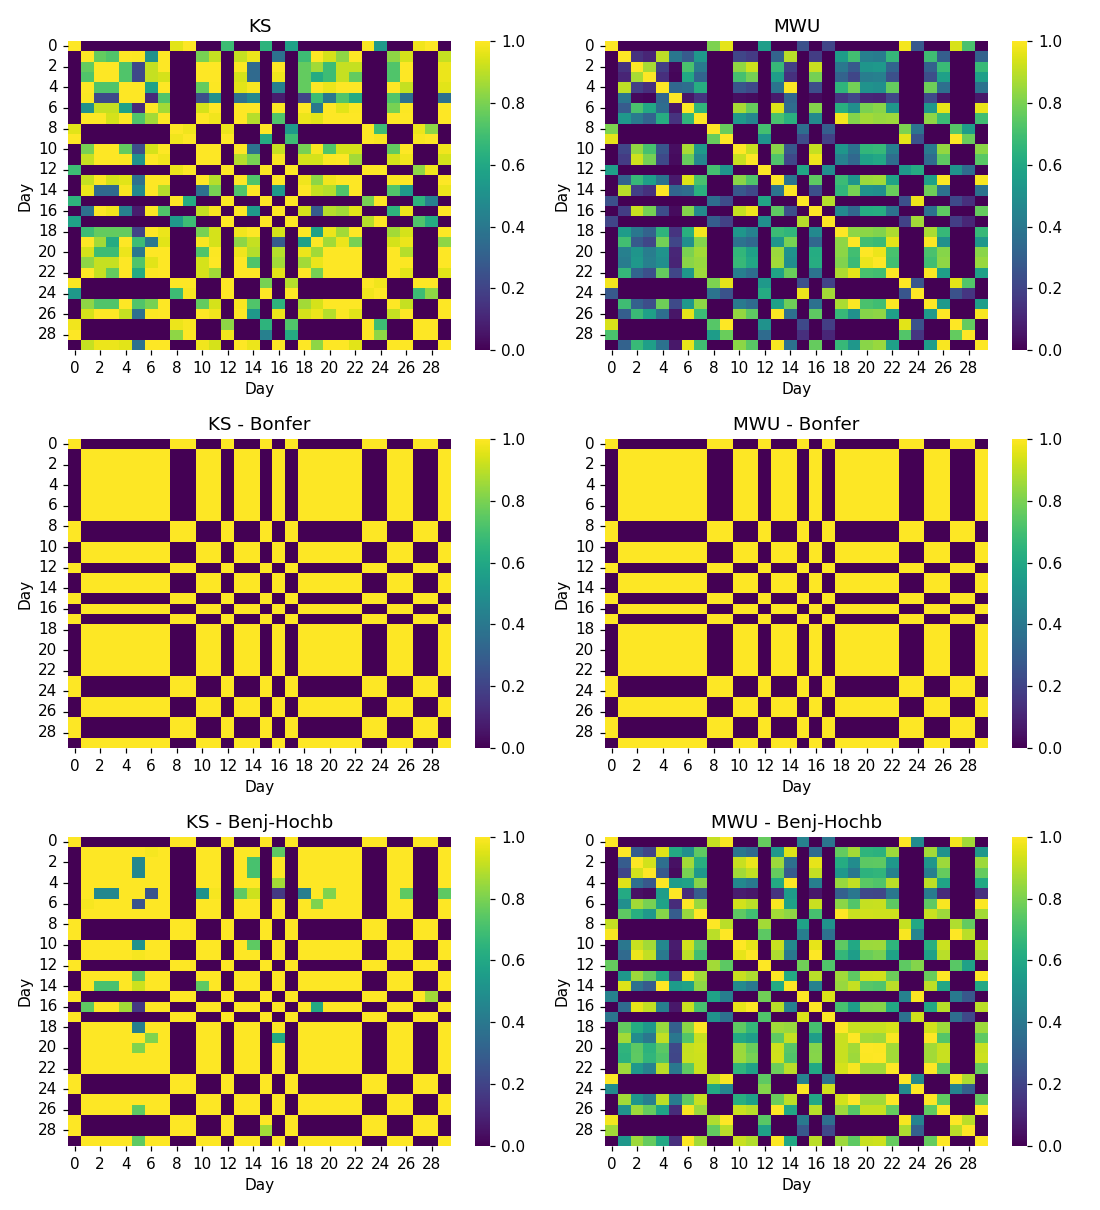

In [212]:
fig, axs = plt.subplots(3, 2, figsize=(10, 11))

plot_heatmap(ks_p_matrix, 'KS', axs[0, 0])
plot_heatmap(mwu_p_matrix, 'MWU', axs[0, 1])

plot_heatmap(ks_p_matrix_corrected_bonf, 'KS - Bonfer', axs[1, 0])
plot_heatmap(mwu_p_matrix_corrected_bonf, 'MWU - Bonfer', axs[1, 1])

plot_heatmap(ks_p_matrix_corrected_bh, 'KS - Benj-Hochb', axs[2, 0])
plot_heatmap(mwu_p_matrix_corrected_bh, 'MWU - Benj-Hochb', axs[2, 1])

plt.tight_layout()
plt.show()

### k samples/ windowing

In [100]:
window_size = 5 
n_days = len(days)

friedman_stats = []
anderson_stats = []

significant_changes = []

In [101]:
for i in range(n_days - window_size + 1):
    window_days = days[i:i + window_size]
    samples = [df[df['date'] == day]['value1'] for day in window_days]

    try:
        anderson_stat, _, _ = anderson_ksamp(samples)
    except ValueError as e:
        anderson_stat = np.nan

    anderson_stats.append(anderson_stat)

    if i > 0 and (np.isnan(anderson_stat) or abs(anderson_stat - anderson_stats[i-1]) > 20):
        significant_changes.append(window_days[-1])
        
print("Significant changes detected on days:", significant_changes)

C:\Users\Vasiliy\AppData\Local\Temp/ipykernel_27524/3143216525.py:13: UserWarning: p-value floored: true value smaller than 0.001
  anderson_stat, _, _ = anderson_ksamp(samples)
C:\Users\Vasiliy\AppData\Local\Temp/ipykernel_27524/3143216525.py:13: UserWarning: p-value capped: true value larger than 0.25
  anderson_stat, _, _ = anderson_ksamp(samples)


Significant changes detected on days: [numpy.datetime64('2023-01-06T00:00:00.000000000'), numpy.datetime64('2023-01-09T00:00:00.000000000'), numpy.datetime64('2023-01-10T00:00:00.000000000'), numpy.datetime64('2023-01-14T00:00:00.000000000'), numpy.datetime64('2023-01-15T00:00:00.000000000'), numpy.datetime64('2023-01-16T00:00:00.000000000'), numpy.datetime64('2023-01-21T00:00:00.000000000'), numpy.datetime64('2023-01-23T00:00:00.000000000'), numpy.datetime64('2023-01-24T00:00:00.000000000'), numpy.datetime64('2023-01-25T00:00:00.000000000'), numpy.datetime64('2023-01-28T00:00:00.000000000')]


In [102]:
anderson_ksamp_dates = np.array(significant_changes)
anderson_ksamp_pred_days = (anderson_ksamp_dates.astype('datetime64[D]') - anderson_ksamp_dates.astype('datetime64[M]')).astype(int) + 1

In [103]:
anderson_ksamp_pred_days

array([ 6,  9, 10, 14, 15, 16, 21, 23, 24, 25, 28])

In [104]:
sorted(drift_days)

[0, 8, 9, 12, 15, 17, 23, 24, 27, 28]

### PSI

In [106]:
%%time

psi_matrix = np.zeros((n_days, n_days)) 

for i, day1 in enumerate(days):
    for j, day2 in enumerate(days):
        if i != j:
            data1 = df[df['date'] == day1]['value1']
            data2 = df[df['date'] == day2]['value1']    

            psi_matrix[i, j] = calculate_psi(data1,data2)


Wall time: 1.3 s


In [232]:
%%time

calculate_psi(df[df['date'] == dates[0]]['value4'], df[df['date'] == dates[1]]['value4'])
pass

Wall time: 8.98 ms


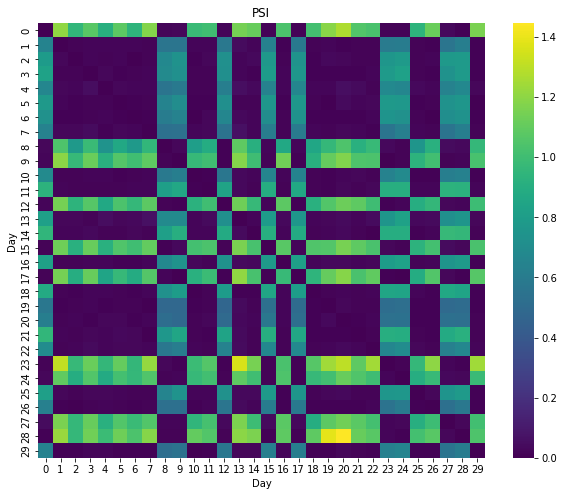

In [107]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
plot_heatmap(psi_matrix, 'PSI', axs)

# PCA (2 components) with image similarity metrics 

In [108]:
pca = PCA(n_components=2)

In [233]:
%%time

pca.fit(df.drop(['date'],axis=1))
df_2d = pca.transform(df.drop(['date'],axis=1))
df_2d = pd.concat([df['date'], pd.DataFrame(df_2d)], axis=1)

Wall time: 74.2 ms


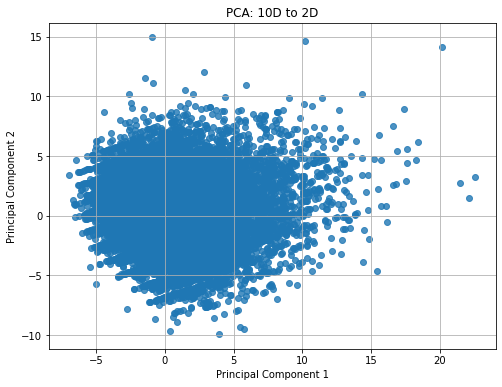

In [116]:
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[0], df_2d[1], alpha=0.8)
plt.title('PCA: 10D to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [160]:
i=0
for date in df_2d['date'].unique():
    day_data = df_2d[df_2d['date'] == date]
    
    plt.figure(figsize=(6, 4))
    plt.scatter(day_data[0], day_data[1], color='black', s = 3)
    plt.title(f'Value1 vs Value2 at {days_val[i]}')
    plt.xlabel('Value1')
    plt.ylabel('Value2')

    plt.savefig(f'PCAimgs/df2d_{days_val[i]}.png')
    i+=1
    plt.close()

In [161]:
df_2dimgs=[imread(f'PCAimgs/df2d_{i}.png', as_gray=True) for i in days_val]

In [162]:
mse_matrix = np.ones((n_days, n_days)) 
cosine_matrix = np.ones((n_days, n_days))
simm_matrix = np.ones((n_days, n_days))
eucl_matrix = np.ones((n_days, n_days))

In [163]:
%%time

for i, day1 in enumerate(days):
    for j, day2 in enumerate(days):
        if i <= j: 
            mse_matrix[i, j] = mse_matrix[j, i] = mean_squared_error(df_2dimgs[i],df_2dimgs[j])
            cosine_matrix[i, j] = cosine_matrix[j, i] = cosine_sim(df_2dimgs[i],df_2dimgs[j])
            simm_matrix[i, j] = simm_matrix[j, i] = ssim(df_2dimgs[i],df_2dimgs[j], full=False, gradient=False)
            eucl_matrix[i, j] = eucl_matrix[j, i] = euclidean_distance(df_2dimgs[i],df_2dimgs[j])

In [234]:
%%time 

mean_squared_error(df_2dimgs[0],df_2dimgs[0])
pass

Wall time: 50.5 ms


In [235]:
%%time 

cosine_sim(df_2dimgs[0],df_2dimgs[0])
pass

Wall time: 42.9 ms


In [236]:
%%time 

ssim(df_2dimgs[0],df_2dimgs[0])
pass

Wall time: 44.7 ms


In [237]:
%%time 

euclidean_distance(df_2dimgs[0],df_2dimgs[0])
pass

Wall time: 6.99 ms


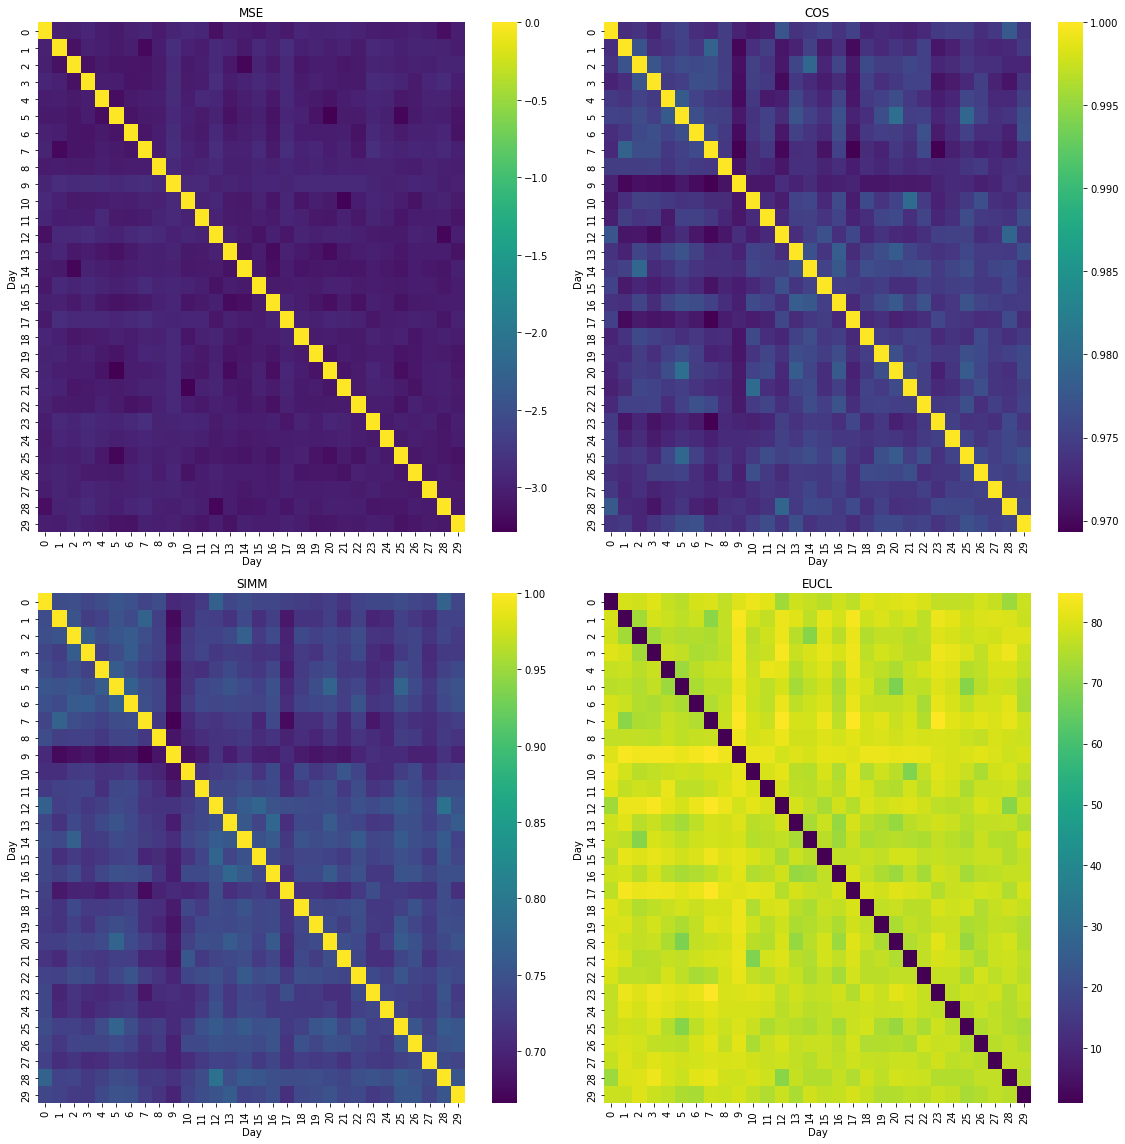

In [167]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

plot_heatmap(np.log(mse_matrix), 'MSE', axs[0, 0])
plot_heatmap(cosine_matrix, 'COS', axs[0, 1])

plot_heatmap(simm_matrix, 'SIMM', axs[1, 0])
plot_heatmap(eucl_matrix, 'EUCL', axs[1, 1])

plt.tight_layout()
plt.show()

# Binary classification with roc-auc

In [199]:
def calculate_roc_auc(partition1, partition2):
    partition1['target'] = 0
    partition2['target'] = 1

    combined_df = pd.concat([partition1, partition2], ignore_index=True)

    X = combined_df.drop('target', axis=1)  
    y = combined_df['target']               
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = CatBoostClassifier(verbose=0) 
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

In [ ]:
%%time

rocauc_matrix = np.full((n_days, n_days), 0.5) 

for i, day1 in enumerate(days):
    for j, day2 in enumerate(days):
        if i > j:
            data1 = df[df['date'] == day1]
            data2 = df[df['date'] == day2]    

            rocauc_matrix[i, j] = rocauc_matrix[j, i] = calculate_roc_auc(data1.drop(['date'],axis=1),data2.drop(['date'],axis=1))

In [239]:
%%time

calculate_roc_auc(df[df['date'] == dates[0]].drop(['date'],axis=1),df[df['date'] == dates[0]].drop(['date'],axis=1))
pass

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Wall time: 3.22 s


<IPython.core.display.Javascript object>


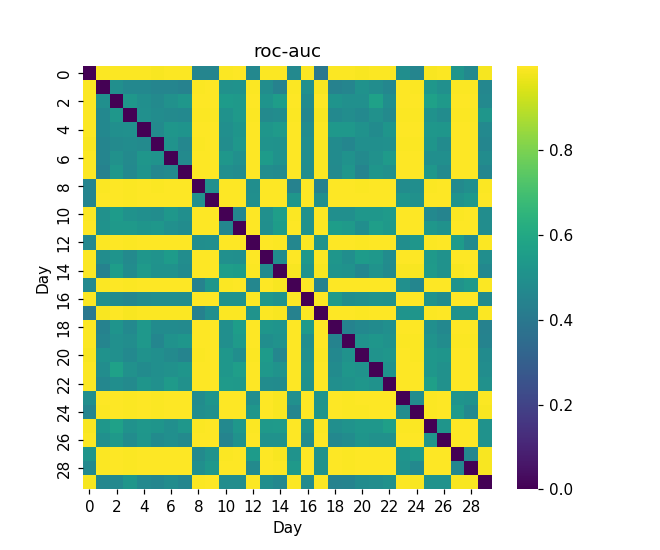

In [214]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
plot_heatmap(rocauc_matrix, 'roc-auc', axs)

# Target drift

In [176]:
np.random.seed(42)

df['target'] = (
    np.sin(df['value1']) * np.log(df['combo1'] + 1) +
    np.sqrt(np.abs(df['combo2']))
)

noise = np.random.normal(loc=0, scale=0.1, size=len(df))
df['target'] += noise

df.fillna(0)

threshold = df['target'].median()

df['target'] = (df['target'] >= threshold).astype(int)

C:\Users\Vasiliy\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[0], df_2d[1], alpha=0.8)
plt.title('PCA: 10D to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [179]:
df_2d = pd.concat([df_2d, df['target']], axis=1)

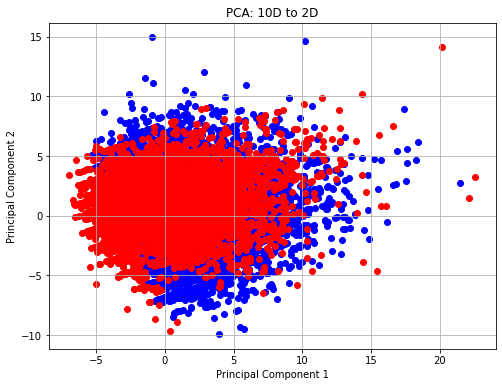

In [183]:
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[df_2d['target']==1][0], df_2d[df_2d['target']==1][1], color = 'blue')
plt.scatter(df_2d[df_2d['target']==0][0], df_2d[df_2d['target']==0][1], color = 'red')
plt.title('PCA: 10D to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


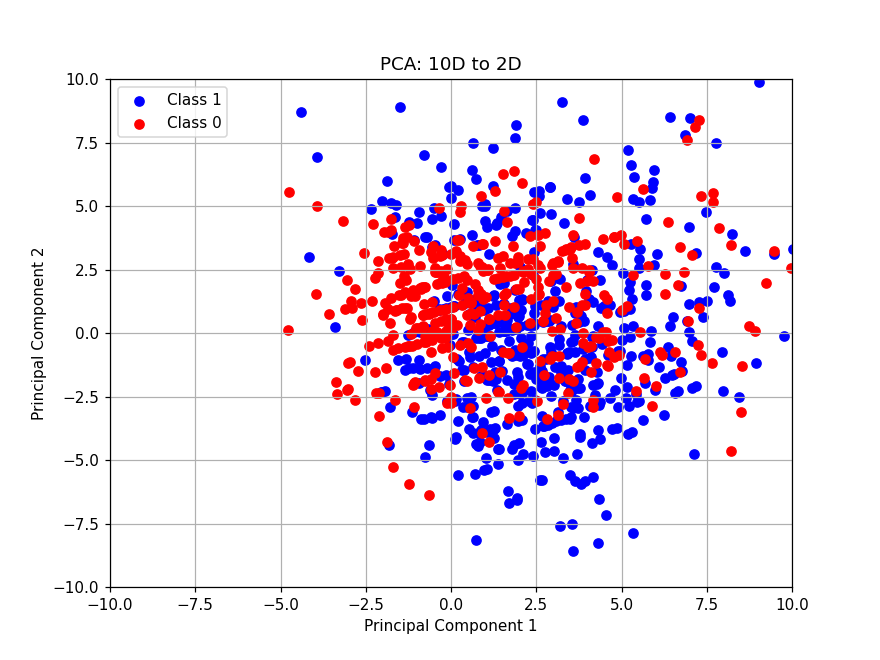

In [197]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True)
ax.set_title('PCA: 10D to 2D')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

scatter1 = ax.scatter([], [], color='blue', label='Class 1')
scatter2 = ax.scatter([], [], color='red', label='Class 0')

def update(i):
    
    day_data = df_2d[df_2d['date'] == i]
    data1 = day_data[day_data['target'] == 1].drop(['date', 'target'], axis = 1)
    data0 = day_data[day_data['target'] == 0].drop(['date', 'target'], axis = 1)
    
    scatter1.set_offsets(data1[[0, 1]].values)
    scatter2.set_offsets(data0[[0, 1]].values)
    
    print(scatter1)

    return scatter1, scatter2,

ani = FuncAnimation(fig, update, frames=list(df_2d['date'].unique()), blit=True)

plt.legend()
plt.show()